# Feature Engineering

Features to add and what question does it answer to?

In [2]:
import pandas as pd

customers_silver_df = pd.read_csv("../data/processed_silver/processed_customers.csv")
transactions_silver_df = pd.read_csv("../data/processed_silver/processed_transactions.csv")

In [2]:
# Fixed exchange rates (Consulting assumption: stable 2020 rates)
exchange_rates = {
    'EUR': 1.0,
    'SEK': 0.097,
    'NOK': 0.093,
    'DKK': 0.134
}

# Convert to EUR
transactions_silver_df['amount_eur'] = transactions_silver_df.apply(
    lambda x: x['amount'] * exchange_rates.get(x['currency'], 1.0), axis=1
)

# Convert timestamp to datetime for subsequent blocks
transactions_silver_df['timestamp'] = pd.to_datetime(transactions_silver_df['timestamp'])

In [3]:
# Initialize the Customer Gold DataFrame
customer_gold_df = transactions_silver_df.groupby('customer_id').agg(
    total_spend_eur=('amount_eur', 'sum')
).reset_index()

customer_gold_df.head()

,customer_id,total_spend_eur
0,1,1125.76832
1,2,1107.65499
2,3,829.78294
3,4,1697.28609
4,5,832.34484


In [4]:
# Calculate mean from the normalized EUR column
# Is this customer a high-ticket buyer or a high-volume/low-value buyer?
avg_spend = transactions_silver_df.groupby('customer_id')['amount_eur'].mean().reset_index()
avg_spend.columns = ['customer_id', 'avg_transaction_value']

customer_gold_df = customer_gold_df.merge(avg_spend, on='customer_id')

In [5]:
# latest transaction in the whole dataset
snapshot_date = transactions_silver_df['timestamp'].max()

# last transaction date per customer and calculate the difference
last_tx = transactions_silver_df.groupby('customer_id')['timestamp'].max().reset_index()
last_tx['recency_days'] = (snapshot_date - last_tx['timestamp']).dt.days

customer_gold_df = customer_gold_df.merge(last_tx[['customer_id', 'recency_days']], on='customer_id')

In [6]:
# Count total transactions per customer
tx_count = transactions_silver_df.groupby('customer_id')['transaction_id'].count().reset_index()
tx_count.columns = ['customer_id', 'transaction_frequency']

customer_gold_df = customer_gold_df.merge(tx_count, on='customer_id')

customer_gold_df.head()

,customer_id,total_spend_eur,avg_transaction_value,recency_days,transaction_frequency
0,1,1125.76832,43.298782,1,26
1,2,1107.65499,48.158913,1,23
2,3,829.78294,51.861434,32,16
3,4,1697.28609,58.527107,24,29
4,5,832.34484,46.241380,51,18


In [7]:
# product_policy.txt: Transactions above 500 EUR are flagged for review.
# identify customer_ids that have triggered this rule in the transactions log.
high_ticket_ids = transactions_silver_df[transactions_silver_df['amount_eur'] > 500]['customer_id'].unique()

customer_gold_df['high_ticket_user'] = customer_gold_df['customer_id'].isin(high_ticket_ids)

In [8]:
# fraud_guidelines.txt: Potential fraud indicators include high transaction frequency.
# We calculate the 90th percentile threshold for our frequency feature.
freq_threshold = customer_gold_df['transaction_frequency'].quantile(0.90)

# Flag customers who exceed this statistical threshold
customer_gold_df['frequent_transactor'] = customer_gold_df['transaction_frequency'] > freq_threshold

,customer_id,total_spend_eur,avg_transaction_value,recency_days,transaction_frequency,high_ticket_user,frequent_transactor
0,1,1125.76832,43.298782,1,26,False,False
1,2,1107.65499,48.158913,1,23,False,False
2,3,829.78294,51.861434,32,16,False,False
3,4,1697.28609,58.527107,24,29,False,False
4,5,832.34484,46.241380,51,18,False,False


In [17]:
# Nordic currency map
nordic_map = {'FI': 'EUR', 'SE': 'SEK', 'NO': 'NOK', 'DK': 'DKK'}

# Identify individual mismatches
temp_trans = transactions_silver_df.merge(customers_silver_df[['customer_id', 'country']], on='customer_id')
temp_trans['is_mismatch'] = temp_trans.apply(lambda x: x['currency'] != nordic_map.get(x['country']), axis=1)

# Count mismatches per customer
cross_border_counts = temp_trans.groupby('customer_id')['is_mismatch'].sum().reset_index()
cross_border_counts.columns = ['customer_id', 'cross_border_count']

# Join to Gold
customer_gold_df = customer_gold_df.merge(cross_border_counts, on='customer_id', how='left')

In [18]:
labeled_tx = transactions_silver_df[transactions_silver_df['category'] != 'uncategorized']

# 2. Find the most frequent labeled category
pref_cat = labeled_tx.groupby(['customer_id', 'category']).size().reset_index(name='count')
pref_cat = pref_cat.sort_values(['customer_id', 'count'], ascending=False).drop_duplicates('customer_id')

# 3. Join and handle the users who only have uncategorized data
customer_gold_df = customer_gold_df.merge(pref_cat[['customer_id', 'category']], on='customer_id', how='left')
customer_gold_df['category'] = customer_gold_df['category'].fillna('general_retail')
customer_gold_df.rename(columns={'category': 'preferred_category'}, inplace=True)

In [21]:
customer_gold_df.head(10)

,customer_id,total_spend_eur,avg_transaction_value,recency_days,transaction_frequency,high_ticket_user,frequent_transactor,cross_border_count,preferred_category
0,1,1125.76832,43.298782,1,26,False,False,19,electronics
1,2,1107.65499,48.158913,1,23,False,False,13,electronics
2,3,829.78294,51.861434,32,16,False,False,13,electronics
3,4,1697.28609,58.527107,24,29,False,False,23,electronics
4,5,832.34484,46.241380,51,18,False,False,14,electronics
5,6,1151.30254,47.970939,56,24,False,False,13,food
6,7,827.87900,39.422810,47,21,False,False,17,food
7,8,1792.03790,61.794410,5,29,False,False,22,electronics
8,9,921.53961,51.196645,1,18,False,False,17,food
9,10,875.23504,48.624169,13,18,False,False,13,electronics


In [9]:
print(customer_gold_df['high_ticket_user'].value_counts())
print('='*50)
print(customer_gold_df['frequent_transactor'].value_counts())

high_ticket_user
False    5000
Name: count, dtype: int64
frequent_transactor
False    4575
True      425
Name: count, dtype: int64


In [11]:
def missing_summary(df):
    total = df.isna().sum()
    percent = (total / len(df)) * 100
    return pd.DataFrame({'missing_count': total, 'missing_percent': percent}).sort_values('missing_percent', ascending=False)

missing_summary(customer_gold_df)

,missing_count,missing_percent
customer_id,0,0.0
total_spend_eur,0,0.0
avg_transaction_value,0,0.0
recency_days,0,0.0
transaction_frequency,0,0.0
high_ticket_user,0,0.0
frequent_transactor,0,0.0


In [22]:
final_customer_gold_df = customers_silver_df.merge(
    customer_gold_df, 
    on='customer_id', 
    how='left'
)

print("Final Gold Table Columns:")
print(final_customer_gold_df.columns.tolist())
final_customer_gold_df.head()

Final Gold Table Columns:
['customer_id', 'country', 'signup_date', 'email', 'total_spend_eur', 'avg_transaction_value', 'recency_days', 'transaction_frequency', 'high_ticket_user', 'frequent_transactor', 'cross_border_count', 'preferred_category']


,customer_id,country,signup_date,email,total_spend_eur,avg_transaction_value,recency_days,transaction_frequency,high_ticket_user,frequent_transactor,cross_border_count,preferred_category
0,1,DK,2022-01-22,user0@example.com,1125.76832,43.298782,1,26,False,False,19,electronics
1,2,FI,2021-12-22,user1@example.com,1107.65499,48.158913,1,23,False,False,13,electronics
2,3,SE,2023-08-18,user2@example.com,829.78294,51.861434,32,16,False,False,13,electronics
3,4,DK,2022-01-25,user3@example.com,1697.28609,58.527107,24,29,False,False,23,electronics
4,5,DK,2019-09-26,user4@example.com,832.34484,46.241380,51,18,False,False,14,electronics


In [14]:
print("Transaction Silver Table Columns:")
print(transactions_silver_df.columns.tolist())

Transaction Silver Table Columns:
['transaction_id', 'customer_id', 'amount', 'currency', 'timestamp', 'category', 'is_category_imputed', 'is_currency_imputed', 'amount_eur']


# Final Check

In [3]:
customers_gold_df = pd.read_csv("../data/processed_gold/gold_customers.csv")
transactions_gold_df = pd.read_csv("../data/processed_gold/gold_transactions.csv")

In [42]:
print(customers_gold_df.columns.tolist())
print(transactions_gold_df.columns.tolist())

['customer_id', 'country', 'signup_date', 'email', 'total_spend_eur', 'avg_transaction_value', 'transaction_frequency', 'last_tx_date', 'recency_days', 'high_ticket_user', 'cross_border_count']
['transaction_id', 'customer_id', 'amount', 'currency', 'timestamp', 'category', 'is_category_imputed', 'is_currency_imputed', 'amount_eur']


In [43]:
print(customers_gold_df.info())
print('='*50)
print(transactions_gold_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            5000 non-null   int64  
 1   country                5000 non-null   object 
 2   signup_date            5000 non-null   object 
 3   email                  5000 non-null   object 
 4   total_spend_eur        5000 non-null   float64
 5   avg_transaction_value  5000 non-null   float64
 6   transaction_frequency  5000 non-null   int64  
 7   last_tx_date           5000 non-null   object 
 8   recency_days           5000 non-null   int64  
 9   high_ticket_user       5000 non-null   bool   
 10  cross_border_count     5000 non-null   int64  
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 395.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119217 entries, 0 to 119216
Data columns (total 9 columns):
 #   Column               Non

In [44]:
print(customers_gold_df.head())
print('='*50)
print(transactions_gold_df.head())

   customer_id country signup_date              email  total_spend_eur  \
0            1      DK  2022-01-22  user0@example.com       1125.76832   
1            2      FI  2021-12-22  user1@example.com       1107.65499   
2            3      SE  2023-08-18  user2@example.com        829.78294   
3            4      DK  2022-01-25  user3@example.com       1697.28609   
4            5      DK  2019-09-26  user4@example.com        832.34484   

   avg_transaction_value  transaction_frequency         last_tx_date  \
0              43.298782                     26  2020-12-11 15:38:00   
1              48.158913                     23  2020-12-11 14:35:00   
2              51.861434                     16  2020-11-10 05:25:00   
3              58.527107                     29  2020-11-18 15:12:00   
4              46.241380                     18  2020-10-22 05:44:00   

   recency_days  high_ticket_user  cross_border_count  
0             1             False                  19  
1         

In [45]:
print(customers_gold_df.isna().sum().sort_values(ascending=False))
print('='*50)
print(transactions_gold_df.isna().sum().sort_values(ascending=False))

customer_id              0
country                  0
signup_date              0
email                    0
total_spend_eur          0
avg_transaction_value    0
transaction_frequency    0
last_tx_date             0
recency_days             0
high_ticket_user         0
cross_border_count       0
dtype: int64
transaction_id         0
customer_id            0
amount                 0
currency               0
timestamp              0
category               0
is_category_imputed    0
is_currency_imputed    0
amount_eur             0
dtype: int64


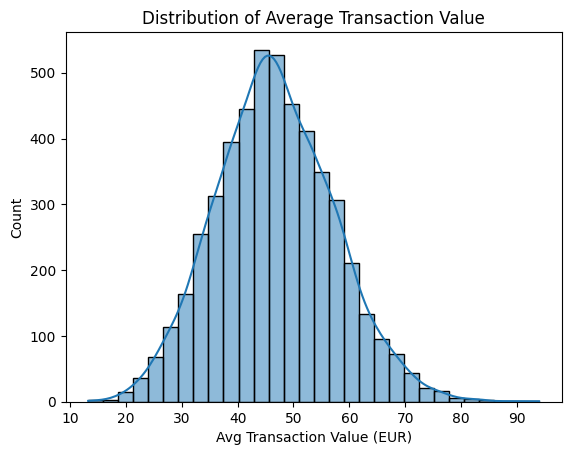

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(customers_gold_df['avg_transaction_value'], bins=30, kde=True)
plt.title("Distribution of Average Transaction Value")
plt.xlabel("Avg Transaction Value (EUR)")
plt.ylabel("Count")
plt.show()

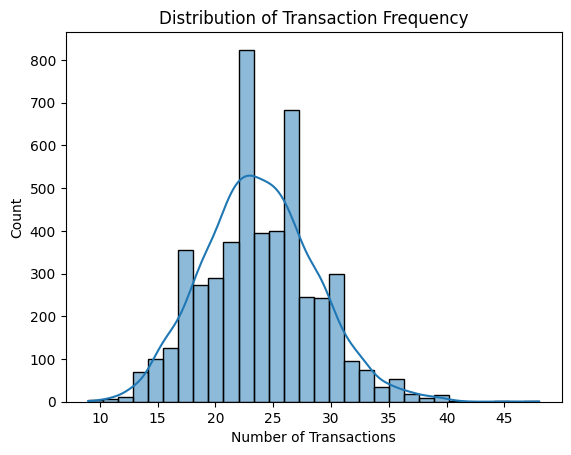

In [47]:
plt.figure()
sns.histplot(customers_gold_df['transaction_frequency'], bins=30, kde=True)
plt.title("Distribution of Transaction Frequency")
plt.xlabel("Number of Transactions")
plt.ylabel("Count")
plt.show()

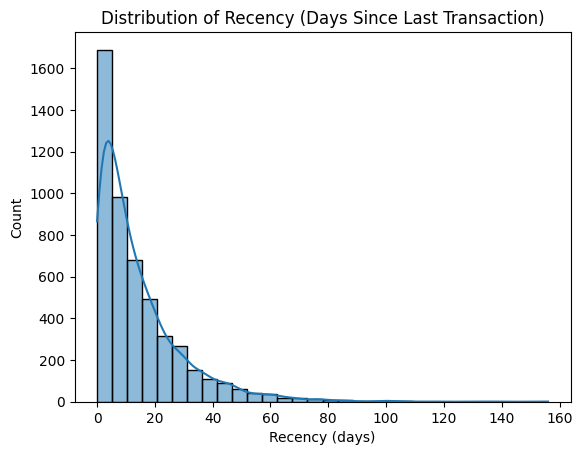

In [48]:
plt.figure()
sns.histplot(customers_gold_df['recency_days'], bins=30, kde=True)
plt.title("Distribution of Recency (Days Since Last Transaction)")
plt.xlabel("Recency (days)")
plt.ylabel("Count")
plt.show()

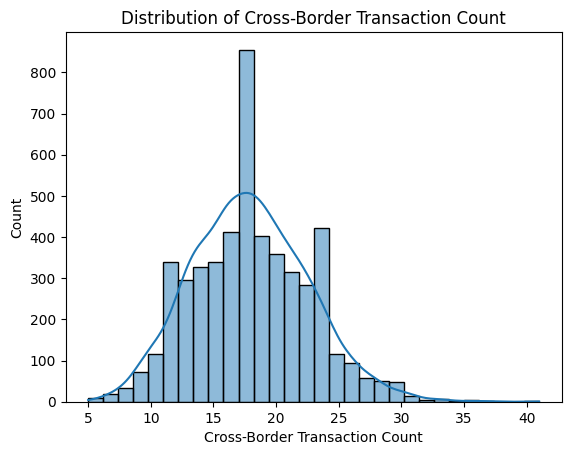

In [49]:
plt.figure()
sns.histplot(customers_gold_df['cross_border_count'], bins=30, kde=True)
plt.title("Distribution of Cross-Border Transaction Count")
plt.xlabel("Cross-Border Transaction Count")
plt.ylabel("Count")
plt.show()

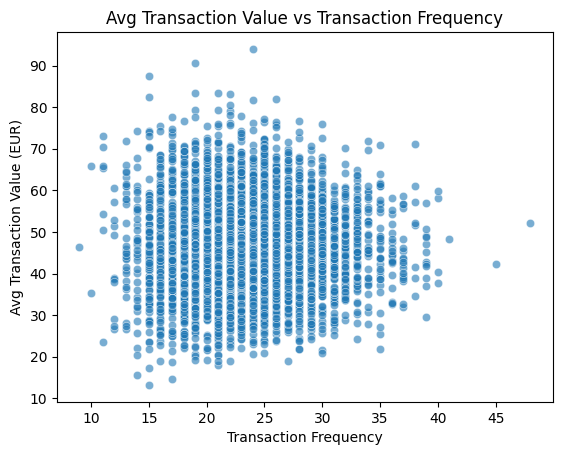

In [50]:
plt.figure()
sns.scatterplot(
    data=customers_gold_df,
    x='transaction_frequency',
    y='avg_transaction_value',
    alpha=0.6
)
plt.title("Avg Transaction Value vs Transaction Frequency")
plt.xlabel("Transaction Frequency")
plt.ylabel("Avg Transaction Value (EUR)")
plt.show()

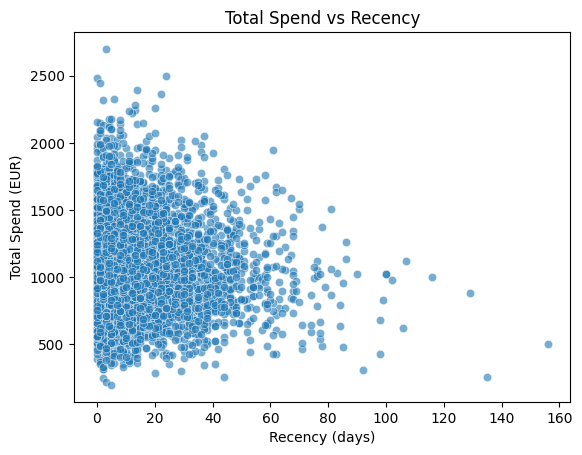

In [51]:
plt.figure()
sns.scatterplot(
    data=customers_gold_df,
    x='recency_days',
    y='total_spend_eur',
    alpha=0.6
)
plt.title("Total Spend vs Recency")
plt.xlabel("Recency (days)")
plt.ylabel("Total Spend (EUR)")
plt.show()
